In [ ]:
from google.colab import drive
import os
import shutil

# Unmount Google Drive if it's already mounted
try:
  drive.flush_and_unmount()
except ValueError:
  pass # Drive was not mounted, so no need to unmount

# Remove any existing contents in the mountpoint
mountpoint = '/content/drive'
if os.path.exists(mountpoint):
    for item in os.listdir(mountpoint):
        item_path = os.path.join(mountpoint, item)
        try:
            if os.path.isfile(item_path) or os.path.islink(item_path):
                os.unlink(item_path)
            elif os.path.isdir(item_path):
                shutil.rmtree(item_path)
        except Exception as e:
            print(f"Error removing {item_path}: {e}")

# Mount Google Drive
drive.mount(mountpoint)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Install required packages
!pip install --upgrade ultralytics
!pip install --upgrade -U ray[tune]
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

from PIL import Image
import cv2

from ultralytics import YOLO

# Disable wandb for Kaggle environment
!wandb disabled

%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 MB 12.4 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.3.0
    Uninstalling click-8.3.0:
      Successfully uninstalled click-8.3.0
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
W&B disabled.


In [ ]:
class CFG:
    DEBUG = False # Set to True to make quick experiments
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 42

    # classes for car detection
    CLASSES = ['truck', 'bus', 'car', 'motorcycle']

    NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # training
    EPOCHS = 3 if DEBUG else 5
    BATCH_SIZE = 8

    BASE_MODEL = 'yolov8n' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x, yolov9c, yolov9e
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'car_detection_{EPOCHS}_epochs'

    OPTIMIZER = "AdamW" # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 1e-3
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-5
    DROPOUT = 0.2
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.1

    # paths
    CUSTOM_DATASET_DIR = r'/content/drive/MyDrive/archive'
    OUTPUT_DIR = r'/content/drive/MyDrive/working' # Corrected path

In [ ]:
# --- Dataset YAML Configuration ---
# Create YAML configuration for the dataset

# Ensure output directory exists
os.makedirs(CFG.OUTPUT_DIR, exist_ok=True)

dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'), # Using val as test if no separate test folder
    'nc': CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
}

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [ ]:
# --- YAML File Handling ---
# Read YAML file
def read_yaml_file(file_path):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

# Print YAML data with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- truck
- bus
- car
- motorcycle
nc: 4
test: /content/drive/MyDrive/archive/valid
train: /content/drive/MyDrive/archive/train
val: /content/drive/MyDrive/archive/valid



In [ ]:
# --- Image Display Functions ---
def display_image(image_path, print_info=True, hide_axis=False):
    """Display image from path"""
    # Check if the image file exists
    if not os.path.exists(image_path):
        print(f"Error: The file {image_path} does not exist.")
        return

    # Open the image
    img = Image.open(image_path)

    # Print image info if needed
    if print_info:
        print(f"Image Path: {image_path}")
        print(f"Image Size: {img.size}")
        print(f"Image Mode: {img.mode}")

    # Display the image
    plt.imshow(img)
    if hide_axis:
        plt.axis('off')
    plt.show()

def plot_random_images_from_folder(folder_path, num_images=10, seed=CFG.SEED):
    """Plot random images from a folder"""
    random.seed(seed)

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        print(f"Warning: Only {len(image_files)} images available in the folder")
        num_images = len(image_files)

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for i, file_name in enumerate(selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))

        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]

        ax.imshow(img)
        ax.axis('off')

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()


--- Displaying Random Training Images ---


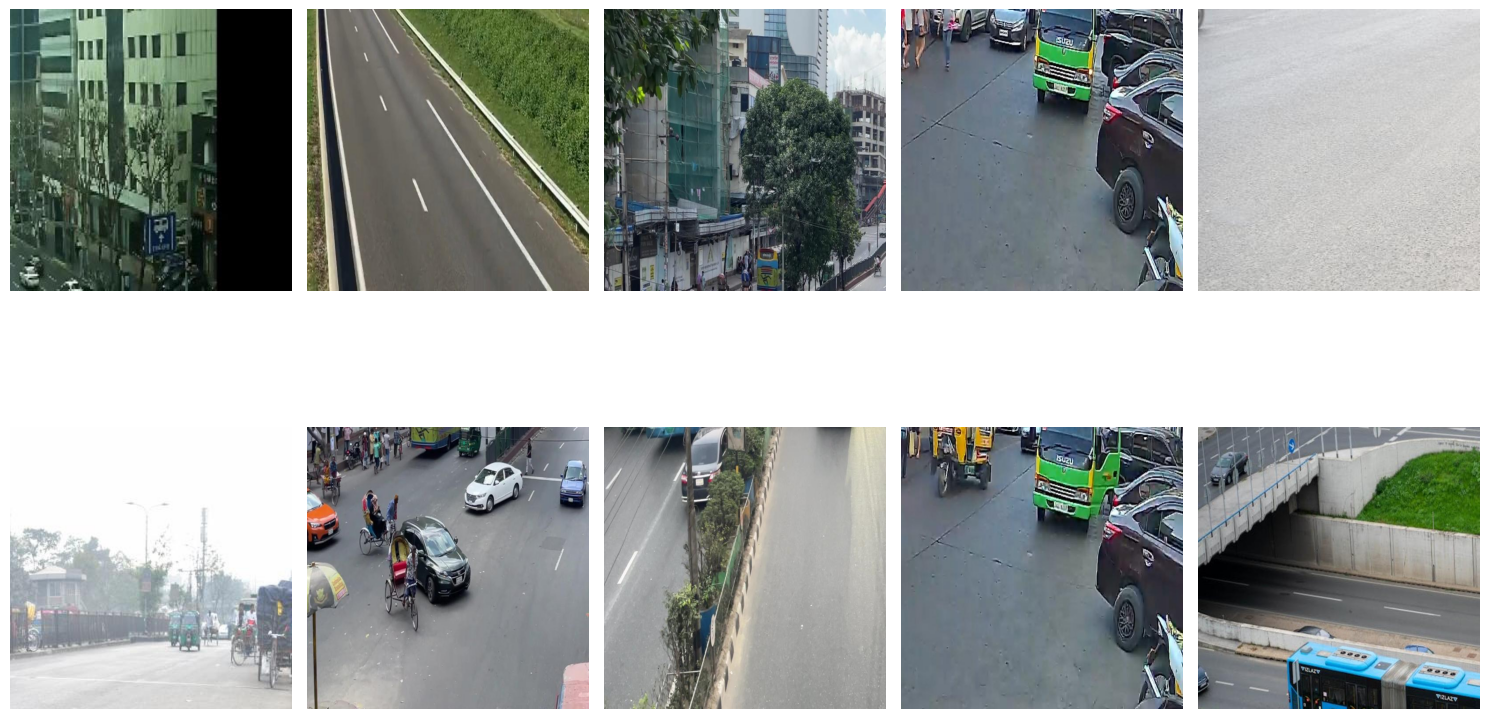

In [ ]:
# --- Display Training Images ---
# Show example images from the dataset
train_image_path = os.path.join(CFG.CUSTOM_DATASET_DIR, 'train', 'images')
if os.path.exists(train_image_path):
    print("\n--- Displaying Random Training Images ---")
    plot_random_images_from_folder(train_image_path, num_images=10, seed=CFG.SEED)


--- Image Properties After Resizing ---
{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}
Image Path: /content/drive/MyDrive/archive/train/images/img471_jpg.rf.59dbde1b98a776068d0e5ffa3b66a168.jpg
Image Size: (640, 640)
Image Mode: RGB


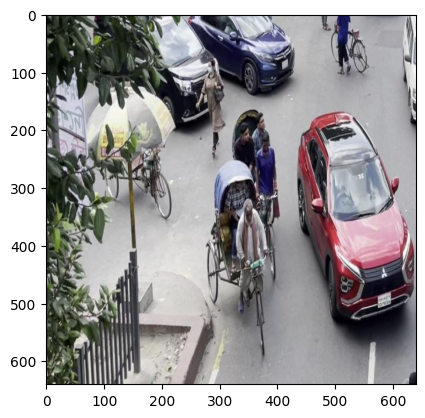

In [ ]:
# --- Image Properties ---
# Find an example image for testing
example_image_path = None
for dirname, _, filenames in os.walk(CFG.CUSTOM_DATASET_DIR):
    for filename in filenames:
        if filename.endswith(('.jpg', '.png', '.jpeg')):
            example_image_path = os.path.join(dirname, filename)
            break
    if example_image_path:
        break

def get_image_properties(image_path, new_size=(640, 640)):
    """Get properties of an image after resizing"""
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Resize the image to the new size
    img_resized = cv2.resize(img, new_size)

    # Get resized image properties
    properties = {
        "width": img_resized.shape[1],      # Width of resized image
        "height": img_resized.shape[0],     # Height of resized image
        "channels": img_resized.shape[2] if len(img_resized.shape) == 3 else 1,  # Number of channels
        "dtype": img_resized.dtype,         # Data type of the image
    }

    return properties, img_resized

# Get image properties for model input
if example_image_path:
    img_properties, img_resized = get_image_properties(example_image_path, new_size=(640, 640))
    print("\n--- Image Properties After Resizing ---")
    print(img_properties)
    display_image(example_image_path)

In [ ]:
# --- Dataset Statistics ---
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid']:
    if not os.path.exists(os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')):
        print(f"Warning: {mode} labels directory not found")
        continue

    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    if os.path.exists(path):
        for file in os.listdir(path):
            with open(os.path.join(path, file)) as f:
                lines = f.readlines()

                for line in lines:
                    if line.strip():
                        cls = line.strip().split()[0]
                        if cls in class_idx:
                            class_count[class_idx[cls]] += 1

        data_len[mode] = len(os.listdir(path))
        class_stat[mode] = class_count

        class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

if class_info:
    dataset_stats_df = pd.DataFrame(class_info)
    print("\n--- Dataset Statistics ---")
    with pd.option_context('display.max_columns', None):
        print(dataset_stats_df)


--- Dataset Statistics ---
    Mode  truck   bus    car  motorcycle  Data_Volume
0  train    441  3610  11986        3375         7556
1  valid    109   428   2021         313         1072


In [ ]:
import torch, torchvision
print("Torch:", torch.__version__)
print("Torchvision:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

Torch: 2.8.0+cu126
Torchvision: 0.23.0+cu126
CUDA available: True
GPU: Tesla T4



image 1/1 /content/drive/MyDrive/archive/train/images/img471_jpg.rf.59dbde1b98a776068d0e5ffa3b66a168.jpg: 640x640 6 persons, 2 bicycles, 3 cars, 1 bus, 7.8ms
Speed: 5.5ms preprocess, 7.8ms inference, 50.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/drive/MyDrive/predict_results
1 label saved to /content/drive/MyDrive/predict_results/labels

--- Model Class Names ---
{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 

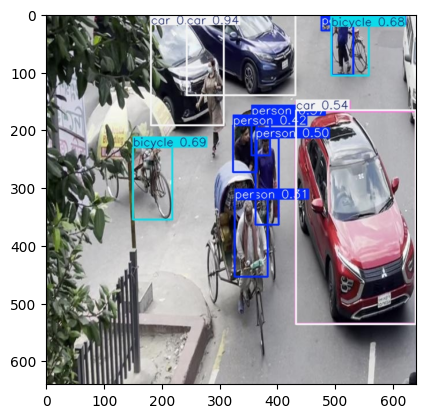

In [ ]:
# --- Test Model Prediction ---
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

if example_image_path:
    results = model.predict(
        source=example_image_path,
        conf=0.30,
        device=0,   # ✅ GPU số 0 (RTX 3050)
        imgsz=(img_properties['height'], img_properties['width']),
        save=True,
        save_txt=True,
        save_conf=True,
        exist_ok=True,
        project="/content/drive/MyDrive",   # ✅ Lưu toàn bộ về ổ D
        name="predict_results"        # ✅ Thư mục con cho kết quả
    )

    # Hiển thị danh sách class
    classes = model.names
    print("\n--- Model Class Names ---")
    print(classes)

    # Xử lý đường dẫn file kết quả
    example_image_inference_output = os.path.basename(example_image_path)

    # Đường dẫn ảnh dự đoán được YOLO lưu
    predicted_image_path = os.path.join("/content/drive/MyDrive/predict_results", example_image_inference_output)
    if os.path.exists(predicted_image_path):
        print("\n--- Test Prediction with Base Model ---")
        display_image(predicted_image_path)
    else:
        print(f"⚠️ Không tìm thấy ảnh dự đoán tại: {predicted_image_path}")

In [ ]:
from ultralytics import YOLO
import os
import torch
import pandas as pd

BASE_OUTPUT = "/content/drive/MyDrive/working"
DATA_YAML = os.path.join(BASE_OUTPUT, "data.yaml")

print("\n🚀 TRAIN YOLO11m - START\n")
print(f"CUDA: {torch.cuda.is_available()} - {torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU Mode")

# Load YOLO11m model
model = YOLO("yolov8n.pt")

# Train
results = model.train(
    data=DATA_YAML,
    project=f"/content/drive/MyDrive/runs/train",
    name="yolov8n_exp",
    imgsz=640,
    epochs=10,
    batch=16,
    patience=20,
    device=0,
    save=True,
    val=True,
    save_period=-1,
    augment=True,
)

print("\nTraining done!")
results_dir = results.results_dir.replace("train", "detect") if "train" in results.results_dir else results.results_dir
print("Results saved to:", results.results_dir)

# Detect weights folder
weights_dir = os.path.join(results.results_dir, "weights")
best_model = os.path.join(weights_dir, "best.pt")
last_model = os.path.join(weights_dir, "last.pt")

model_path = best_model if os.path.exists(best_model) else last_model
print(f"Using model: {model_path}")

# Test sample images
test_images = [
    "/content/drive/MyDrive/test_sample1.jpg",
    "/content/drive/MyDrive/test_sample2.jpg"
]
print("\nTesting predictions...")

for img in test_images:
    if os.path.exists(img):
        model.predict(
            source=img,
            conf=0.25,
            device=0,
            save=True,
            project=f"/content/drive/MyDrive/predictions",
            name="results",
            exist_ok=True
        )
        print(f"Predicted: {os.path.basename(img)}")

print("\n DONE — Model ready to use!\n")



🚀 TRAIN YOLO11m - START

CUDA: True - Tesla T4
Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/working/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_exp, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overla

AttributeError: 'DetMetrics' object has no attribute 'results_dir'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metrics.
        clear_stats: Clear the stored statistics.
        keys: Return a list of keys for accessing specific metrics.
        mean_results: Calculate mean of detected objects & return precision, recall, mAP50, and mAP50-95.
        class_result: Return the result of evaluating the performance of an object detection model on a specific class.
        maps: Return mean Average Precision (mAP) scores per class.
        fitness: Return the fitness of box object.
        ap_class_index: Return the average precision index per class.
        results_dict: Return dictionary of computed performance metrics and statistics.
        curves: Return a list of curves for accessing specific metrics curves.
        curves_results: Return a list of computed performance metrics and statistics.
        summary: Generate a summarized representation of per-class detection metrics as a list of dictionaries.
    

In [ ]:
!pip install --upgrade ultralytics
!pip install --upgrade -U ray[tune]
import warnings
warnings.filterwarnings("ignore")

# Disable wandb for Kaggle environment
!wandb disabled


image 1/1 /content/drive/MyDrive/test_raw/Screenshot 2025-10-10 163257.jpg: 352x640 2 cars, 39.9ms
Speed: 1.7ms preprocess, 39.9ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)
Results saved to /content/drive/MyDrive/test_raw
✅ Ảnh dự đoán lưu tại: /content/drive/MyDrive/test_raw/Screenshot 2025-10-10 163257.jpg


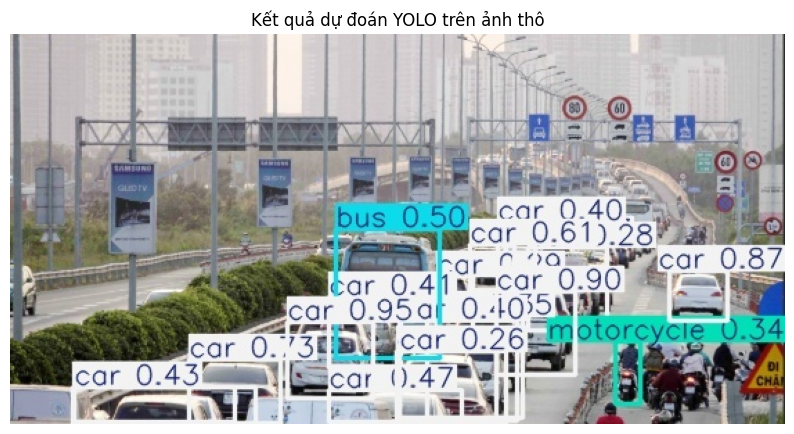

In [ ]:
from ultralytics import YOLO
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt

# --- Load mô hình YOLO đã train ---
model = YOLO("/content/drive/MyDrive/runs/train/yolov8n_exp/weights/best.pt")

# --- Ảnh thô để test ---
raw_image_path = "/content/drive/MyDrive/test_raw/Screenshot 2025-10-10 163257.jpg"  # 👉 thay bằng ảnh thô của bạn

# --- Thư mục lưu kết quả ---
output_dir = "/content/drive/MyDrive/test_raw"

# --- Thực hiện dự đoán ---
results = model.predict(
    source=raw_image_path,
    conf=0.25,                # ngưỡng confidence
    device=0,                 # GPU RTX 3050
    save=True,                # Lưu ảnh dự đoán
    project="/content/drive/MyDrive",
    name="test_raw",          # Tên thư mục con
    exist_ok=True
)

# --- Tự động tìm ảnh YOLO vừa lưu ---
predicted_images = glob.glob(os.path.join(output_dir, "*.jpg")) + glob.glob(os.path.join(output_dir, "*.png"))
if predicted_images:
    latest_image = max(predicted_images, key=os.path.getmtime)
    print(f"✅ Ảnh dự đoán lưu tại: {latest_image}")

    # --- Hiển thị ảnh ---
    img = Image.open(latest_image)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Kết quả dự đoán YOLO trên ảnh thô")
    plt.show()
else:
    print(f"⚠️ Không tìm thấy ảnh dự đoán trong {output_dir}")


In [ ]:
import torch, torchvision
print("Torch:", torch.__version__)
print("Torchvision:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())


In [ ]:
import os, shutil, random

train_img_dir = "/content/drive/MyDrive/archive/train/images"
train_lbl_dir = "/content/drive/MyDrive/archive/train/labels"
val_img_dir = "/content/drive/MyDrive/archive/val/images"
val_lbl_dir = "/content/drive/MyDrive/archive/val/labels"

os.makedirs(val_img_dir, exist_ok=True)
os.makedirs(val_lbl_dir, exist_ok=True)

train_images = [f for f in os.listdir(train_img_dir) if f.endswith(('.jpg', '.png'))]
sample_images = random.sample(train_images, int(len(train_images) * 0.1))  # 10% ảnh

for img in sample_images:
    shutil.copy(os.path.join(train_img_dir, img), os.path.join(val_img_dir, img))
    lbl = img.rsplit('.', 1)[0] + ".txt"
    if os.path.exists(os.path.join(train_lbl_dir, lbl)):
        shutil.copy(os.path.join(train_lbl_dir, lbl), os.path.join(val_lbl_dir, lbl))

print(f"✅ Copied {len(sample_images)} images into val/")

model.train(
    data="/content/drive/MyDrive/working/data.yaml",
    project="/content/drive/MyDrive",
    name="car_detection_full",
    epochs=10,
    imgsz=640,
    batch=16,
    device=0,
    val=True
)

